# 02_DiD_estimates.ipynb

In [8]:
from differences import ATTgt
from differences.did.pscore_cal import pscore_mle
from matplotlib import pyplot as plt

import figure_and_table_constants
import figure_utilities
from analysis_utilities import test_balance, aggregate_by_time_and_plot, \
    aggregate_by_event_time_and_plot, select_controls, add_missing_indicators, prepare_df

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/zestimates_analysis.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/zestimate/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/zestimate/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

In [9]:
# Store list of Zestimate variable names and create dictionaries which map between month variable names to integers.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
value_vars_zestimates = [value_var + "_zestimate" for value_var in value_vars]
month_to_int_dictionary = {key: value + 1 for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key + 1: value for key, value in enumerate(value_vars)}

In [10]:
covariate_exploration_df = select_controls(df, analysis='zestimate', output_directory=OUTPUT_TABLES)
covariate_exploration_df

Dependent Variable  \
                                                                             Zestimate, Dec. 2022   
                                                 \emph{Independent Variable}                        
Panel A: Pre-treatment Outcomes                  twenty_seventeen_zestimate          0.000000e+00   
                                                 change_in_zestimates               1.264429e-118   
Panel B: Census Tract Characteristics            frac_coll_plus2010                  3.096022e-12   
                                                 job_density_2013                    1.355252e-03   
                                                 med_hhinc2016                       6.304640e-05   
                                                 poor_share2010                      6.944582e-01   
                                                 popdensity2010                      1.542249e-46   
                                                 rent_twobed2015                     5.705281e-21   
                                                 share_white2010                     4.438206e-09   
                                                 traveltime15_2010                   2.871181e-41   
Panel C: Case Initiation                         for_cause                           1.375272e-02   
                                                 no_cause                            9.857393e-01   
                                                 non_payment                         3.114295e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                            3.655513e-01   
                                                 hasAttyP                            6.063359e-01   
                                                 isEntityD                           2.171802e-02   
                                                 isEntityP                           6.191860e-01   

                                                                                                
                                                                             Plaintiff victory  
                                                 \emph{Independent Variable}                    
Panel A: Pre-treatment Outcomes                  twenty_seventeen_zestimate       7.869327e-04  
                                                 change_in_zestimates             2.664968e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010               9.264108e-02  
                                                 job_density_2013                 6.372815e-01  
                                                 med_hhinc2016                    2.869576e-02  
                                                 poor_share2010                   7.594566e-03  
                                                 popdensity2010                   7.473481e-03  
                                                 rent_twobed2015                  5.231199e-02  
                                                 share_white2010                  2.785888e-03  
                                                 traveltime15_2010                1.962828e-02  
Panel C: Case Initiation                         for_cause                        6.735141e-01  
                                                 no_cause                         3.232651e-02  
                                                 non_payment                      7.510882e-01  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                         3.382228e-30  
                                                 hasAttyP                         4.867835e-01  
                                                 isEntityD                        3.643074e-01  
                                                 isEntityP                        1.137825e-01

In [11]:
balance_table, pre_treatment_covariates = test_balance(df, 'zestimate', covariate_exploration_df, OUTPUT_TABLES)
balance_table

\
                                                    Cases Won by Plaintiff   
Panel A Zestimate, Jan. 2017                                 291945.810182   
        Change in Zestimate, Jan. 2017 to Jan. 2019           50501.639374   
Panel B Share with bachelor's degree                              0.253948   
        Jobs per square mile (2010)                            4161.509187   
        Median household income (2016)                        52084.777368   
        Population density (2010)                              9018.271853   
        Median two bedroom rent (2015)                         1093.516578   
        Share white (2010)                                        0.602571   
        Share with commute $<$15 minutes (2010)                   0.286995   
Panel C For cause                                                 0.124231   
Panel D Defendant is an entity                                    0.011890   

                                                    Difference in Cases Won by Defendant  \
                                                                              Unweighted   
Panel A Zestimate, Jan. 2017                                                26673.958474   
        Change in Zestimate, Jan. 2017 to Jan. 2019                          2697.849425   
Panel B Share with bachelor's degree                                            0.011026   
        Jobs per square mile (2010)                                           259.780326   
        Median household income (2016)                                       2271.041629   
        Population density (2010)                                             962.558592   
        Median two bedroom rent (2015)                                         33.189130   
        Share white (2010)                                                      0.034148   
        Share with commute $<$15 minutes (2010)                                -0.010680   
Panel C For cause                                                               0.005489   
Panel D Defendant is an entity                                                  0.003741   

                                                                            \
                                                     \emph{p}     Weighted   
Panel A Zestimate, Jan. 2017                         0.000787  3189.168320   
        Change in Zestimate, Jan. 2017 to Jan. 2019  0.266497 -3196.877779   
Panel B Share with bachelor's degree                 0.092641    -0.000363   
        Jobs per square mile (2010)                  0.637281   668.271013   
        Median household income (2016)               0.028696  -211.136108   
        Population density (2010)                    0.007473   644.234299   
        Median two bedroom rent (2015)               0.052312     8.191448   
        Share white (2010)                           0.002786    -0.001060   
        Share with commute $<$15 minutes (2010)      0.019628    -0.005652   
Panel C For cause                                    0.673514    -0.008957   
Panel D Defendant is an entity                       0.364307     0.002656   

                                                               
                                                     \emph{p}  
Panel A Zestimate, Jan. 2017                         0.751626  
        Change in Zestimate, Jan. 2017 to Jan. 2019  0.317073  
Panel B Share with bachelor's degree                 0.964491  
        Jobs per square mile (2010)                  0.365789  
        Median household income (2016)               0.869612  
        Population density (2010)                    0.173041  
        Median two bedroom rent (2015)               0.693400  
        Share white (2010)                           0.935938  
        Share with commute $<$15 minutes (2010)      0.285774  
Panel C For cause                                    0.562657  
Panel D Defendant is an entity                       0.636932

In [12]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_month_variable = treatment_date_variable.replace('date', 'month')

# Generate indicators for missing data.
add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = prepare_df(df, 'zestimate', treatment_date_variable, pre_treatment_covariates, value_vars_zestimates, month_to_int_dictionary)

In [13]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 3000/3000 [00:33<00:00, 88.48it/s] 


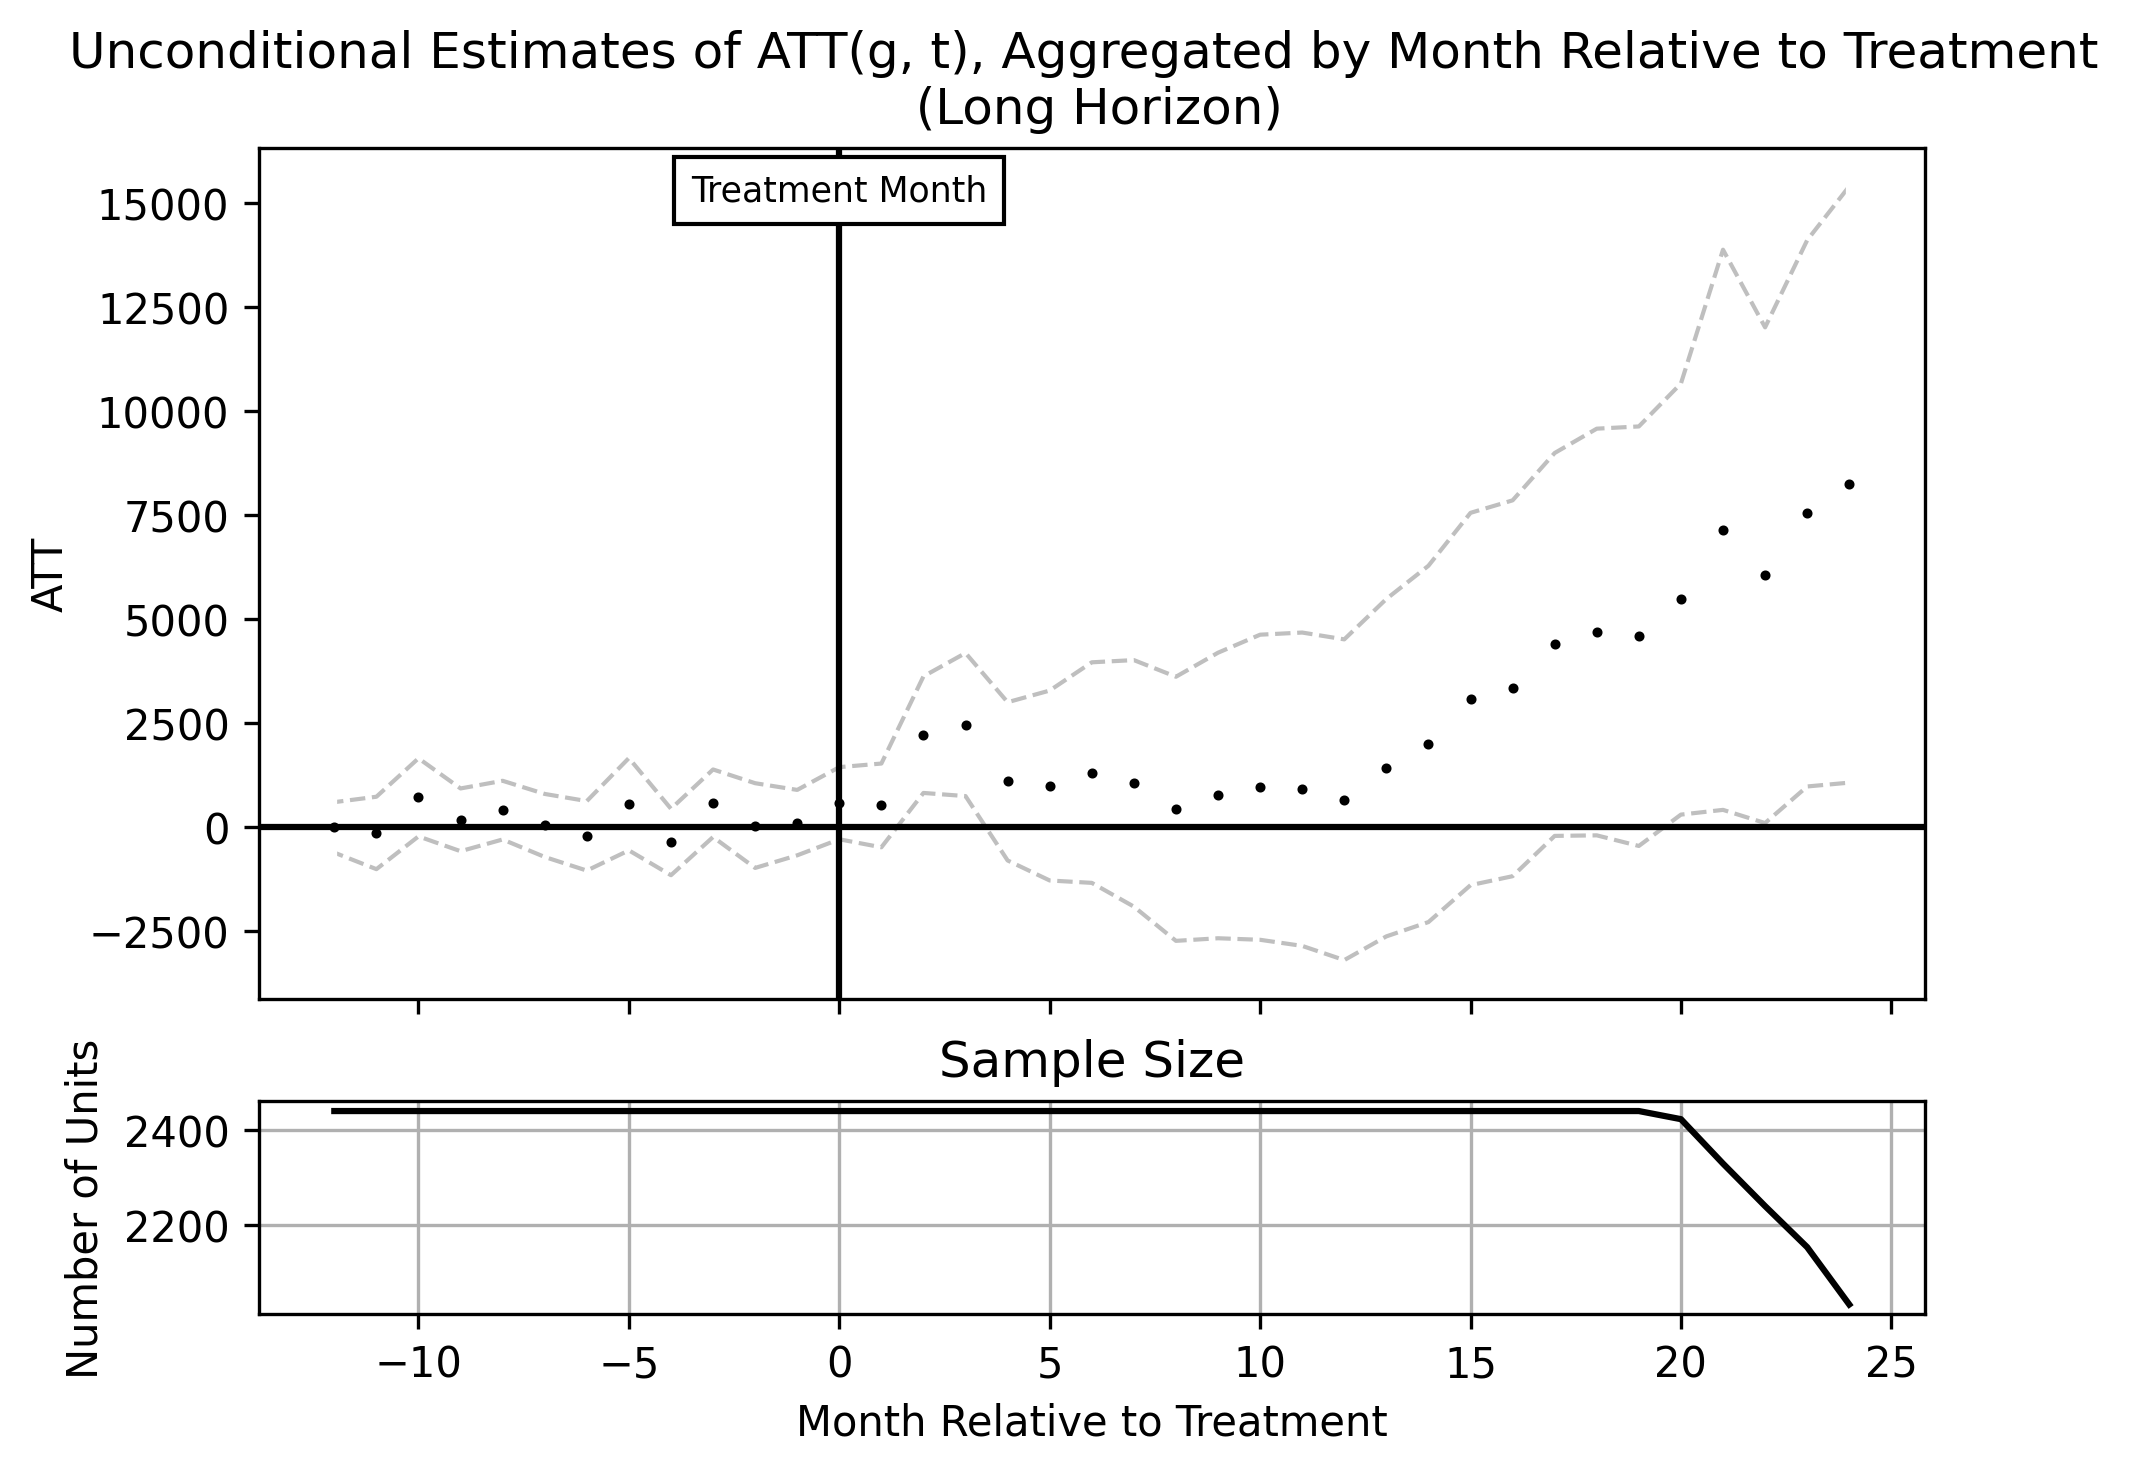

In [14]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=24,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

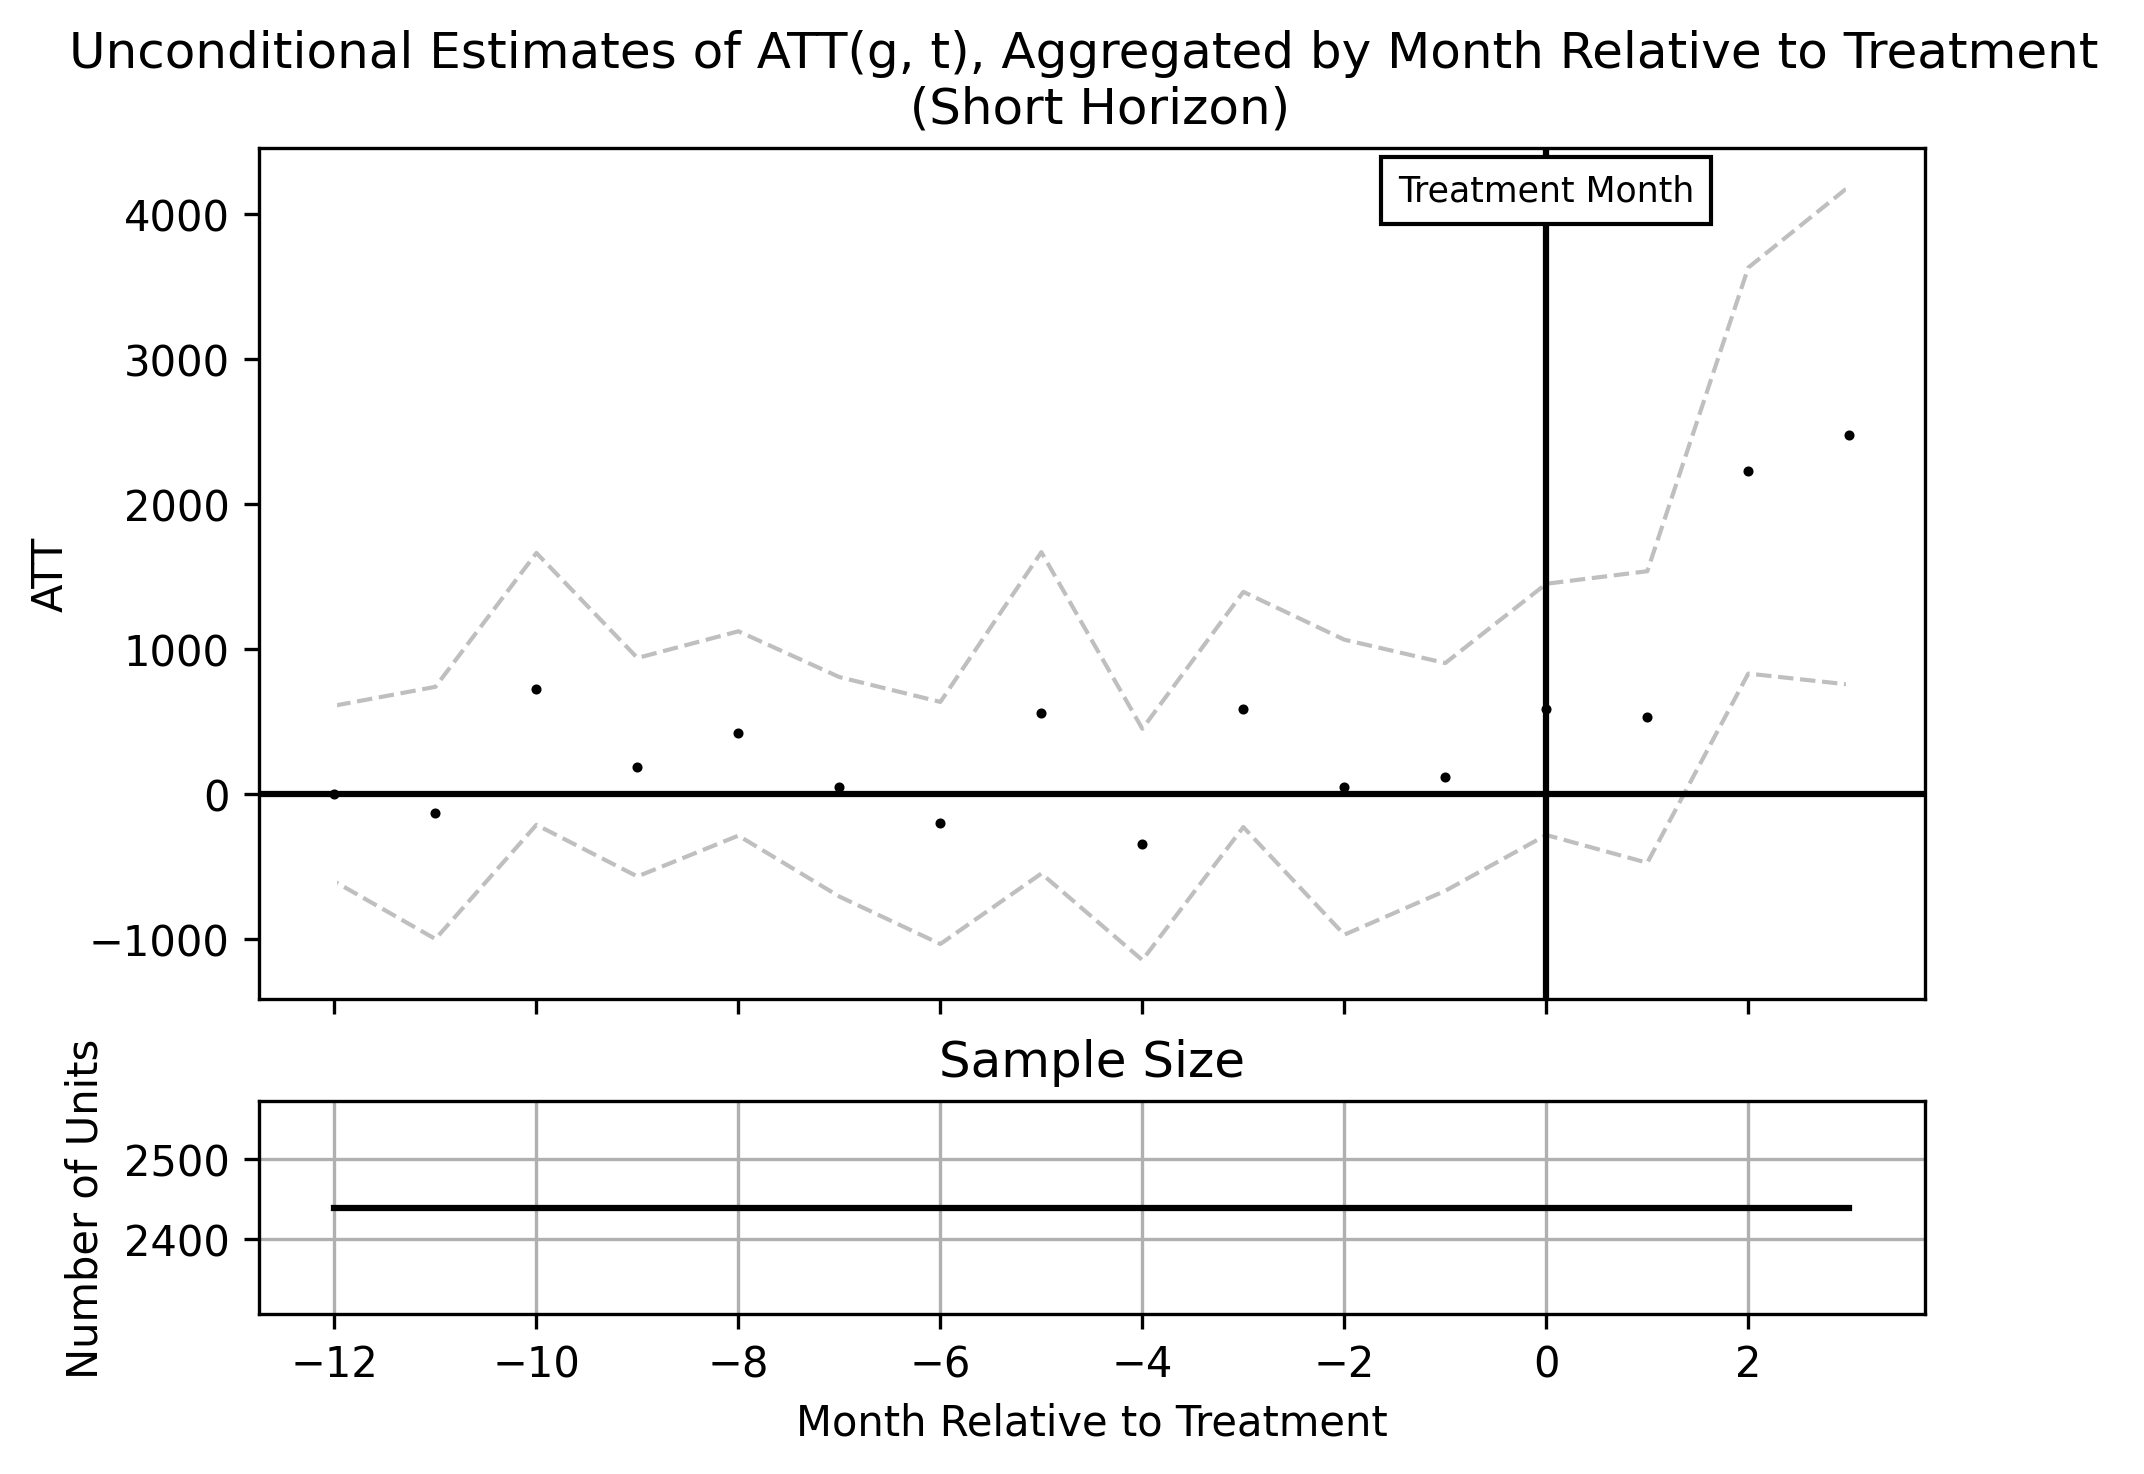

In [15]:
# Plot unconditional ATT(t-g)s on a short horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_short_horizon.png",
                                 start_period=-12, end_period=3,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Short Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

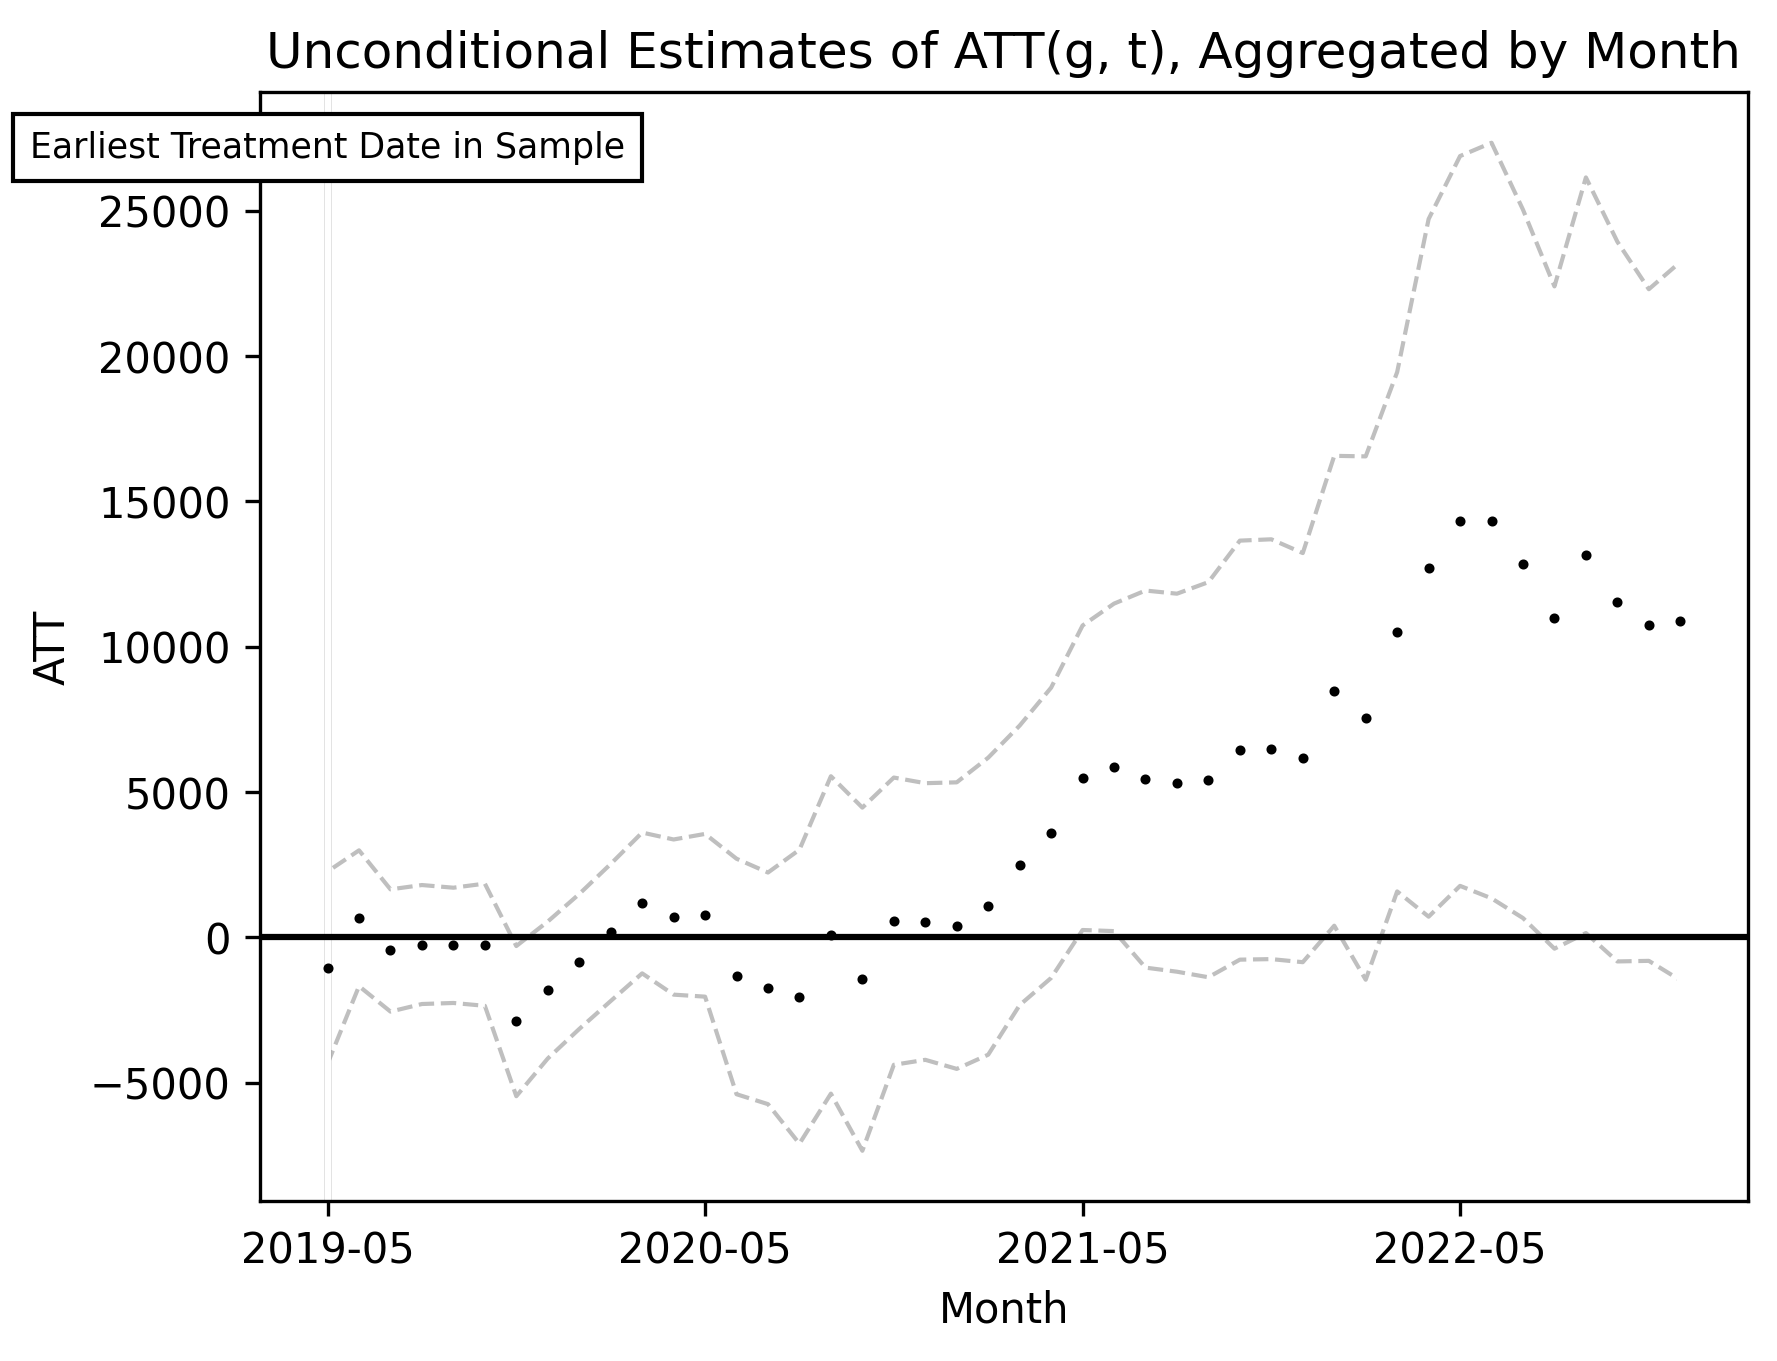

In [16]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

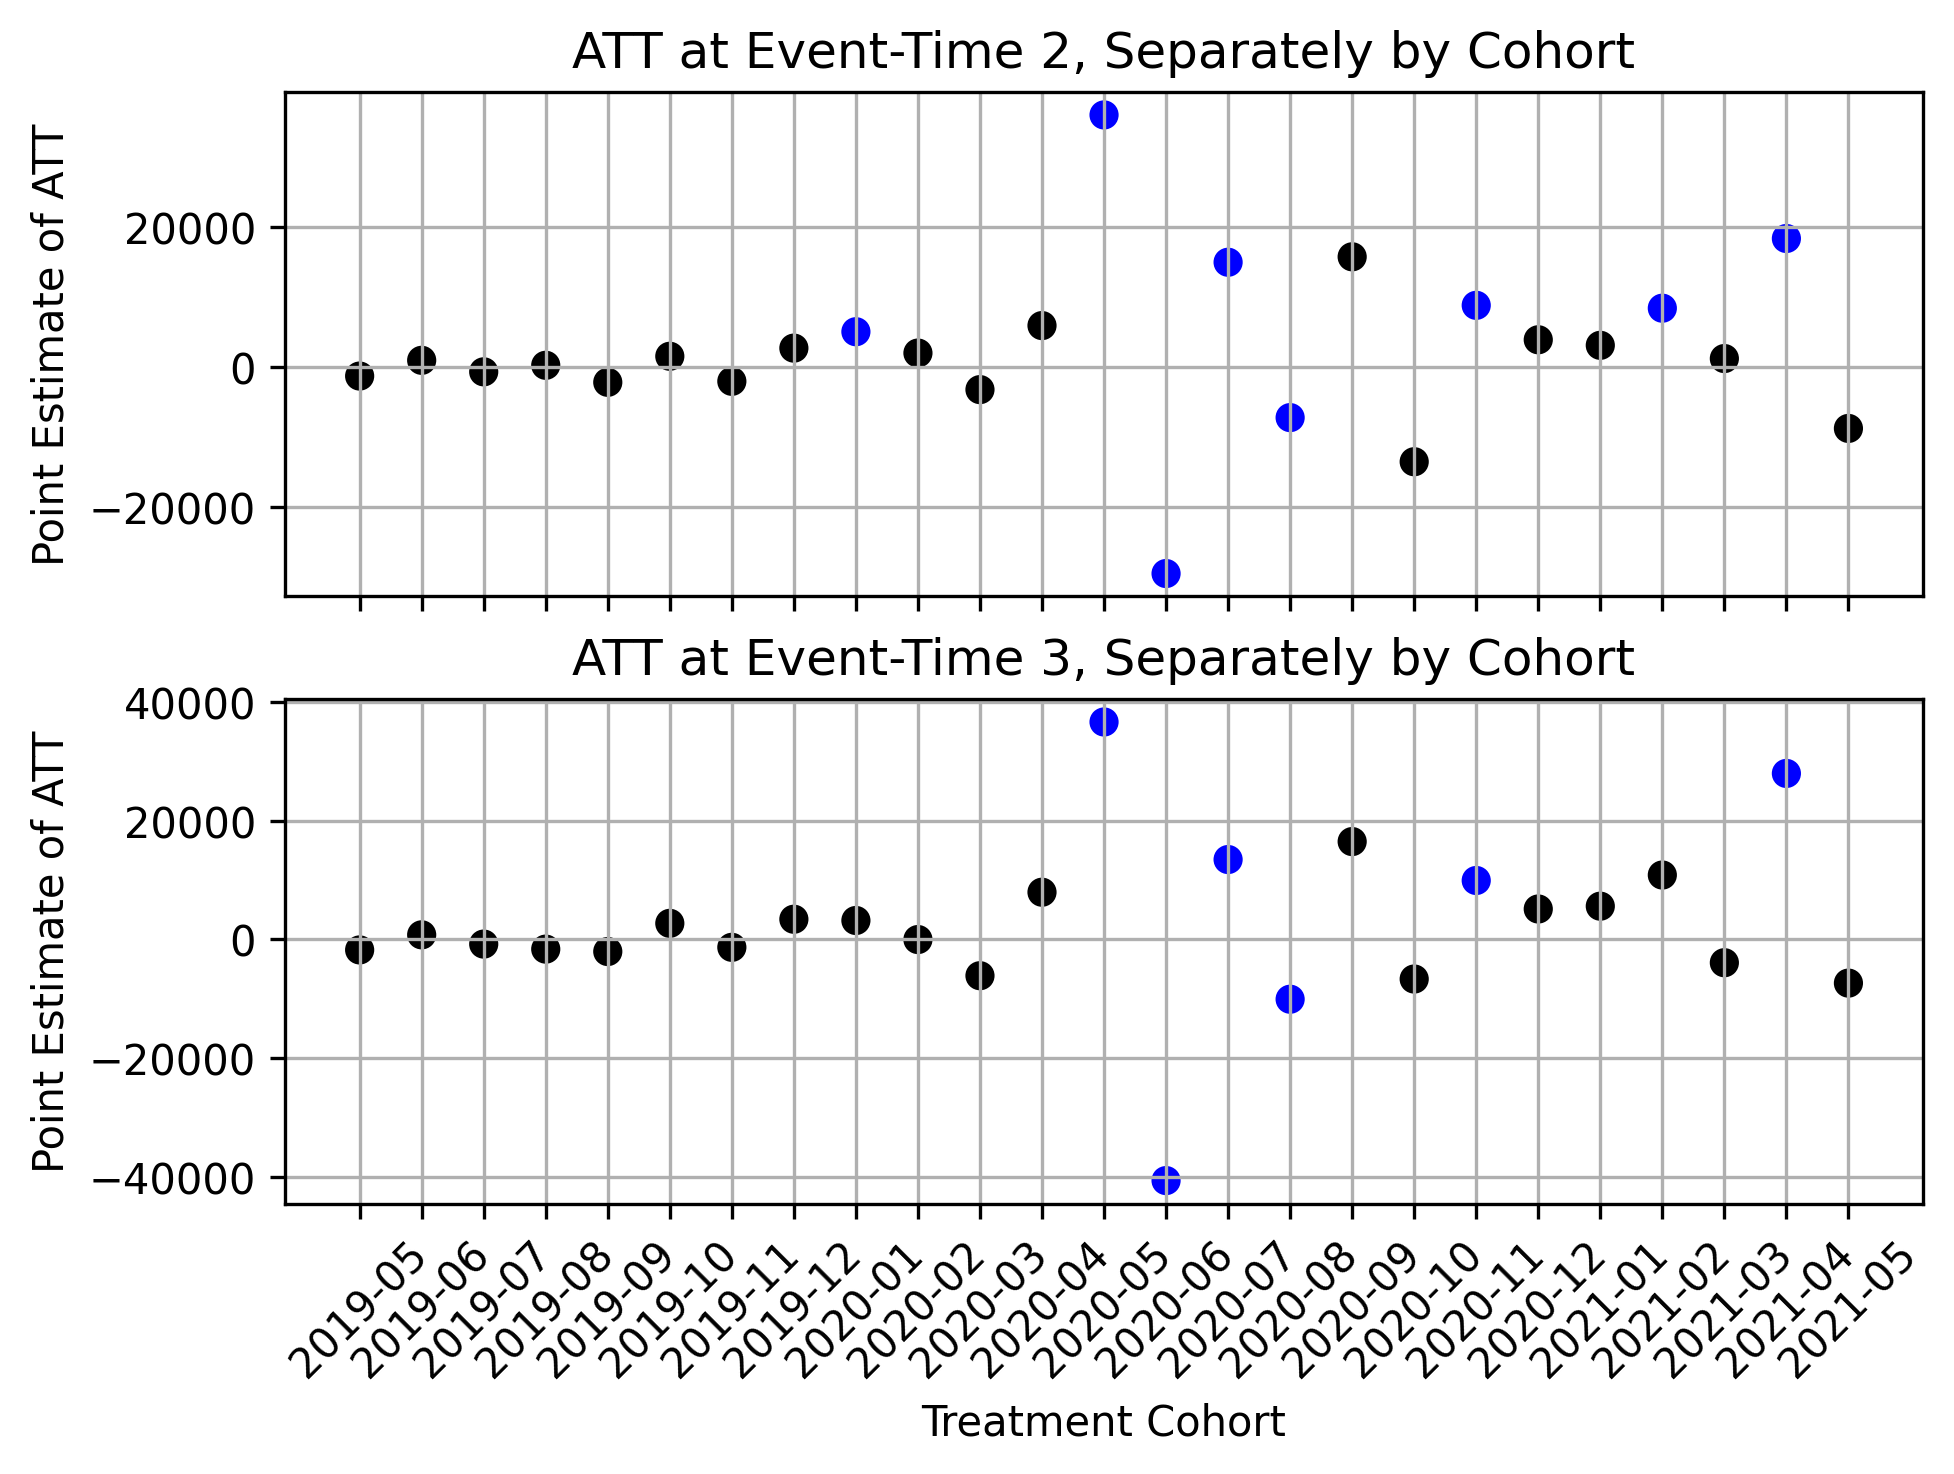

In [17]:
# Analyze heterogeneity in event-time 2 and 3 effects.

# Remove the outer indices of the columns so that we can easily access the ATT estimate and the significance of the estimate.
att_gts = result.copy()
att_gts.columns = att_gts.columns.droplevel(0).droplevel(0)

# Select ATT estimates from event time 2.
event_time_2_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'ATT']
event_time_2_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'zero_not_in_cband']

# Select ATT estimates from event time 3.
event_time_3_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'ATT']
event_time_3_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'zero_not_in_cband']

fig, axes = plt.subplots(2, 1, sharex=True, layout='constrained')

for event_time_i_ATTS, event_time_i_significance, xlabel, ylabel, title, ax in zip([event_time_2_ATTs, event_time_3_ATTs],
                                                                                   [event_time_2_significance, event_time_3_significance],
                                                                                   ["", "Treatment Cohort"],
                                                                                   ["Point Estimate of ATT", "Point Estimate of ATT"],
                                                                                   ["ATT at Event-Time 2, Separately by Cohort",
                                                                                    "ATT at Event-Time 3, Separately by Cohort"],
                                                                                   axes):
    x = pd.Series(event_time_i_ATTS.index.get_level_values(0)).replace(int_to_month_dictionary).values.tolist()
    y = event_time_i_ATTS.values.tolist()
    colors = event_time_i_significance.replace({'*': 'blue', '': 'black'}).values.tolist()
    ax.scatter(x,
               y,
               color=colors)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
axes[1].tick_params('x', rotation=45)
plt.show()

In [18]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = 'zestimate ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]   48%|█████████▌          | 1437/3000 [01:03<01:01, 25.61it/s]/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
Computing ATTgt [workers=10]   48%|█████████▌          | 1441/3000 [01:03<00:57, 26.90it/s]/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/pytho

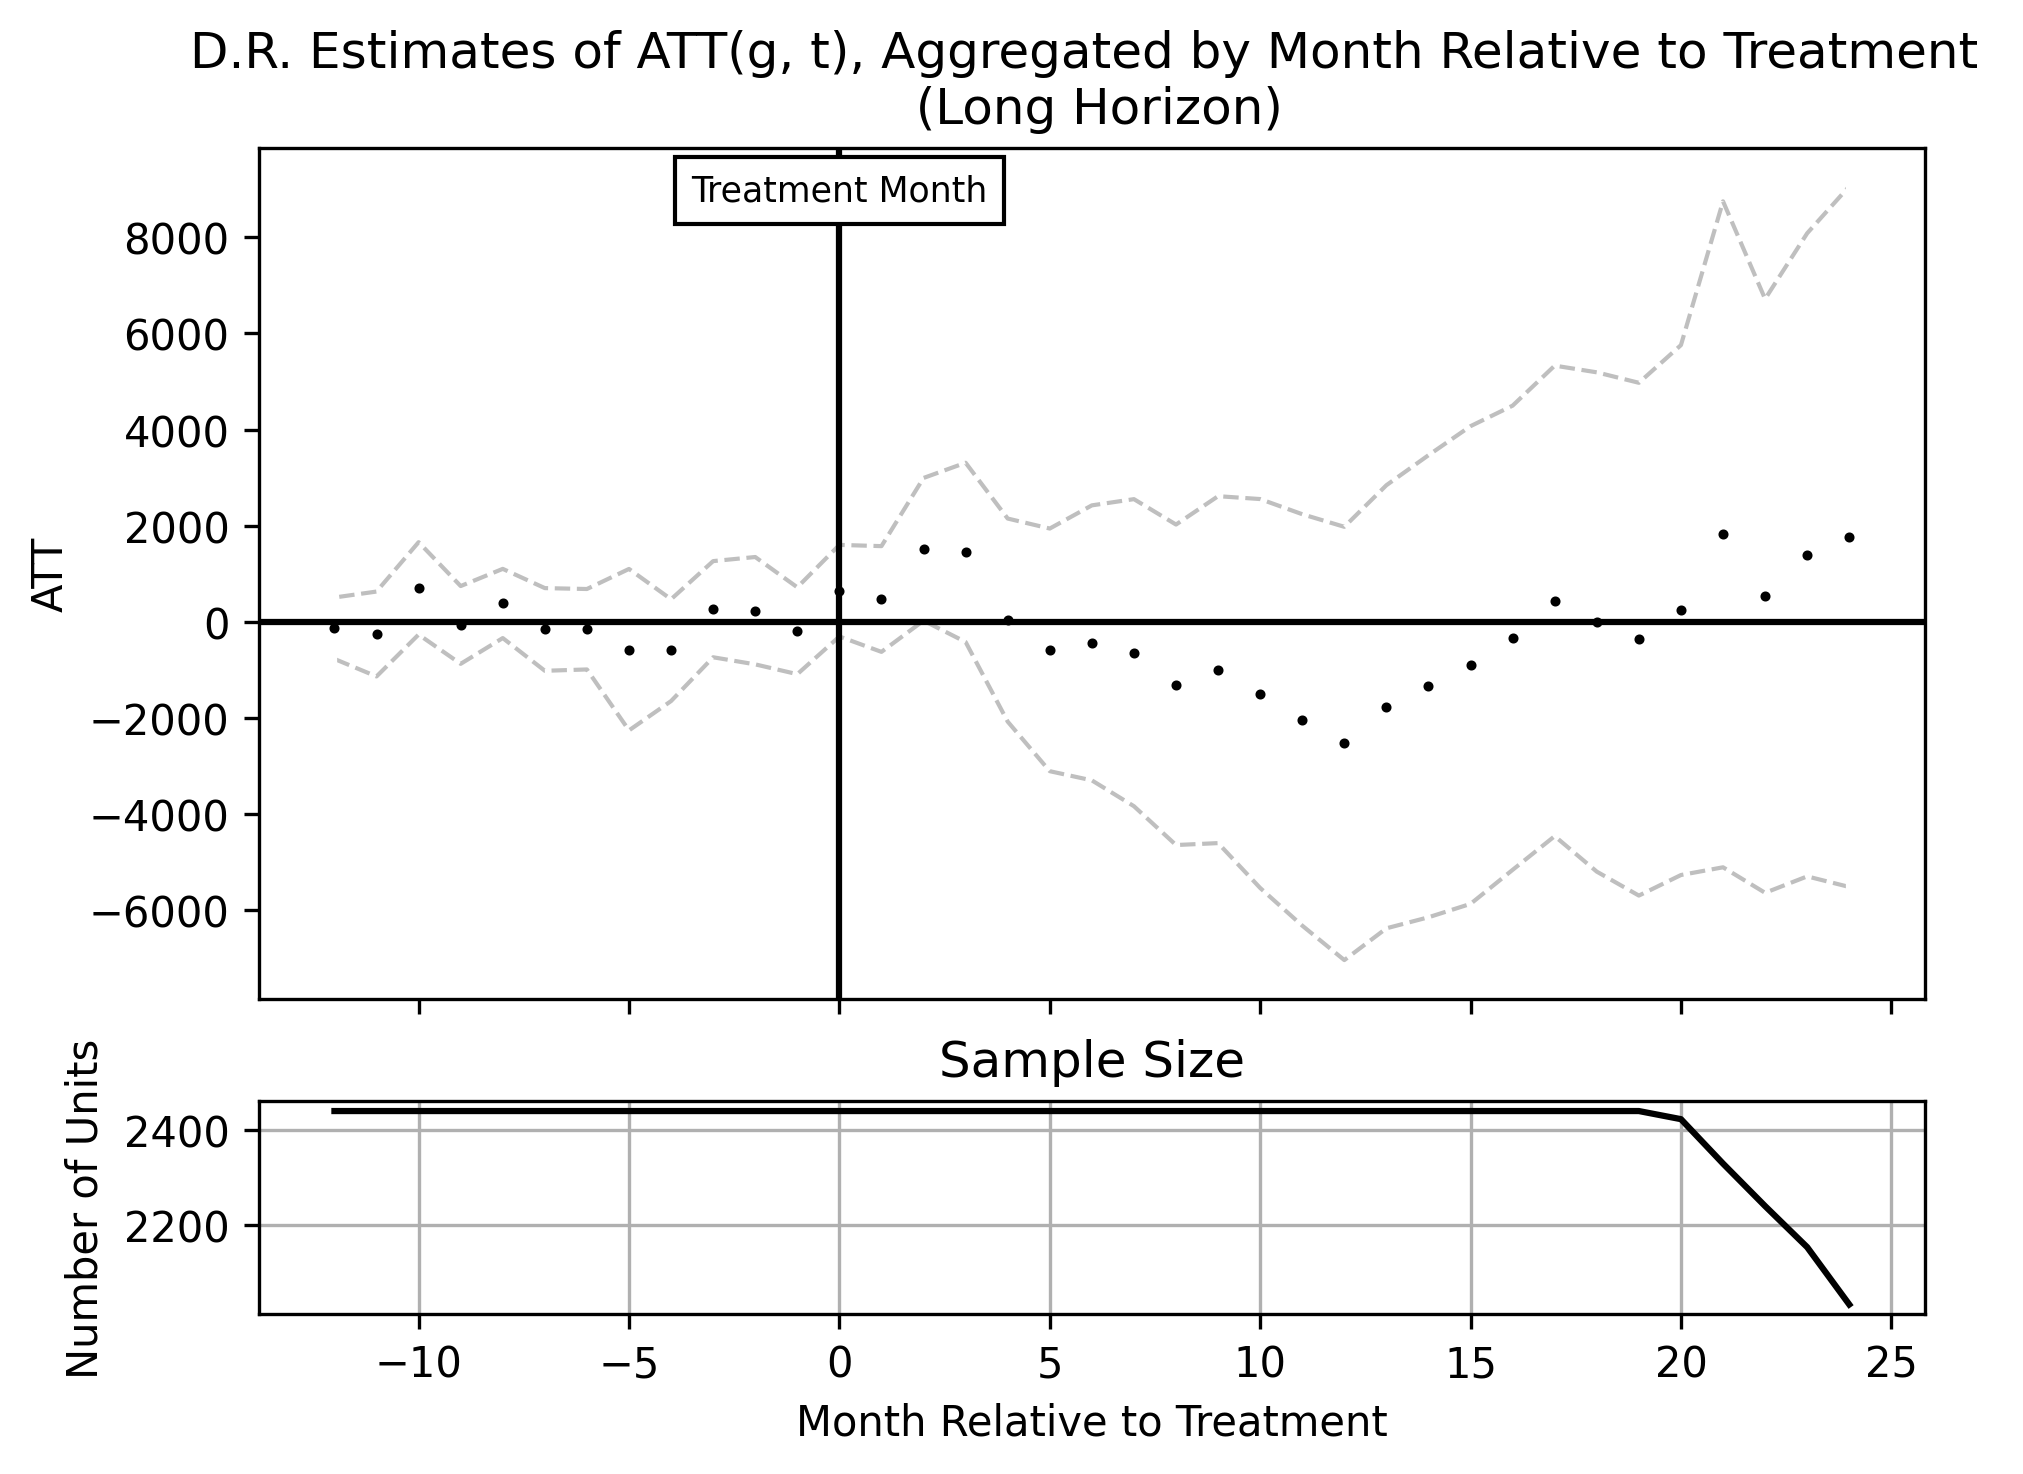

In [19]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=24,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

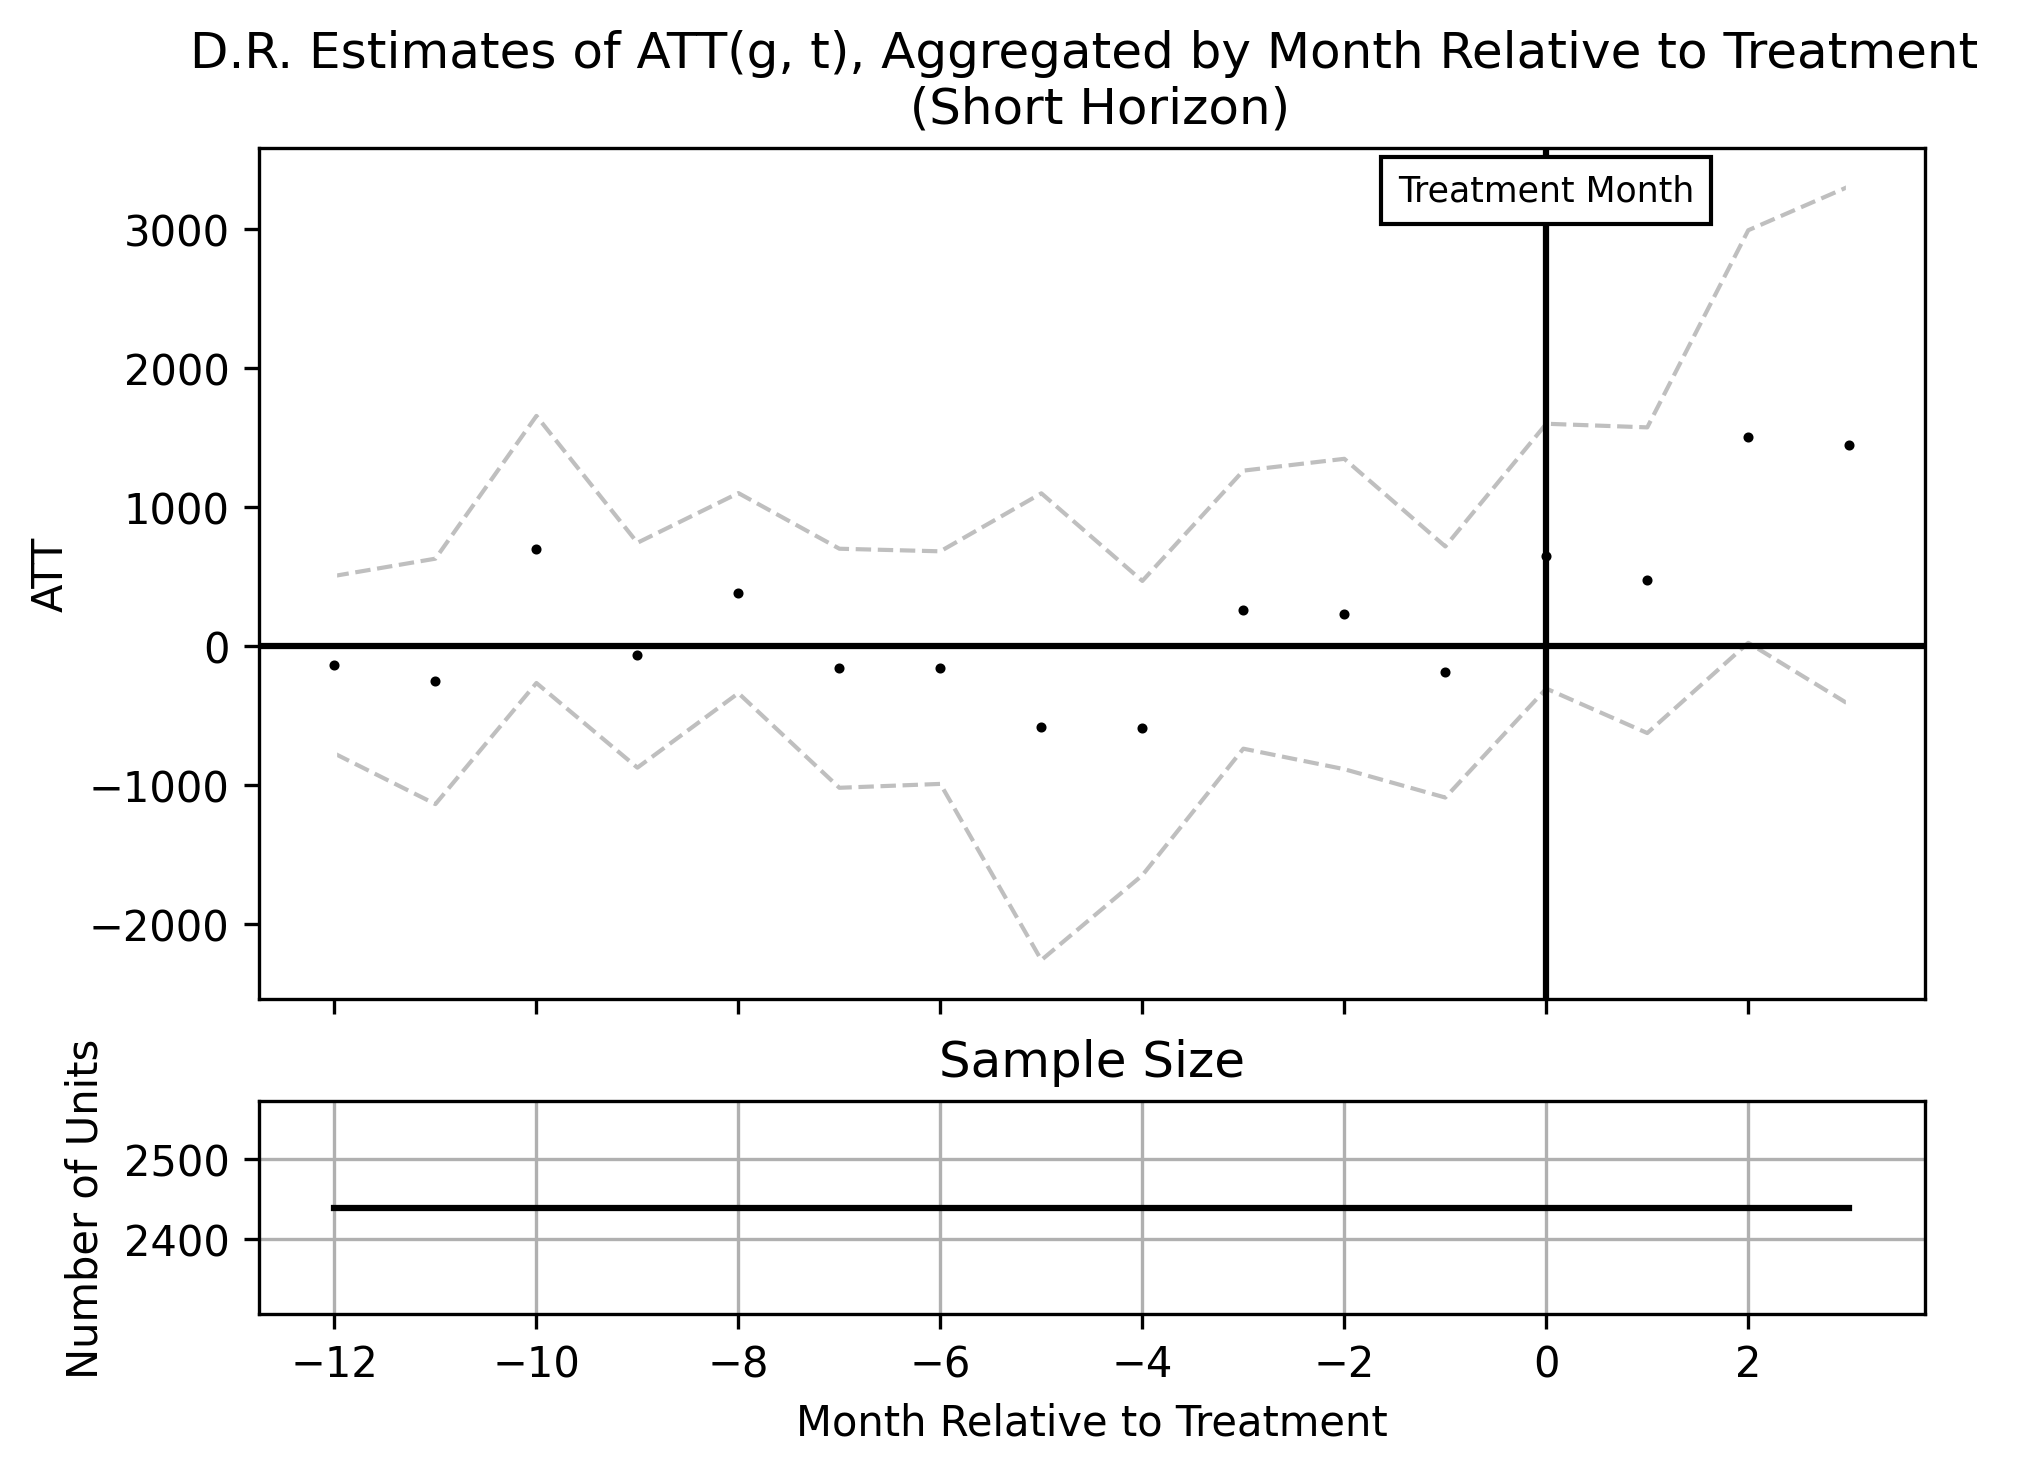

In [20]:
# Plot D.R. ATT(t-g)s on a short horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_short_horizon.png", start_period=-12,
                                 end_period=3,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Short Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

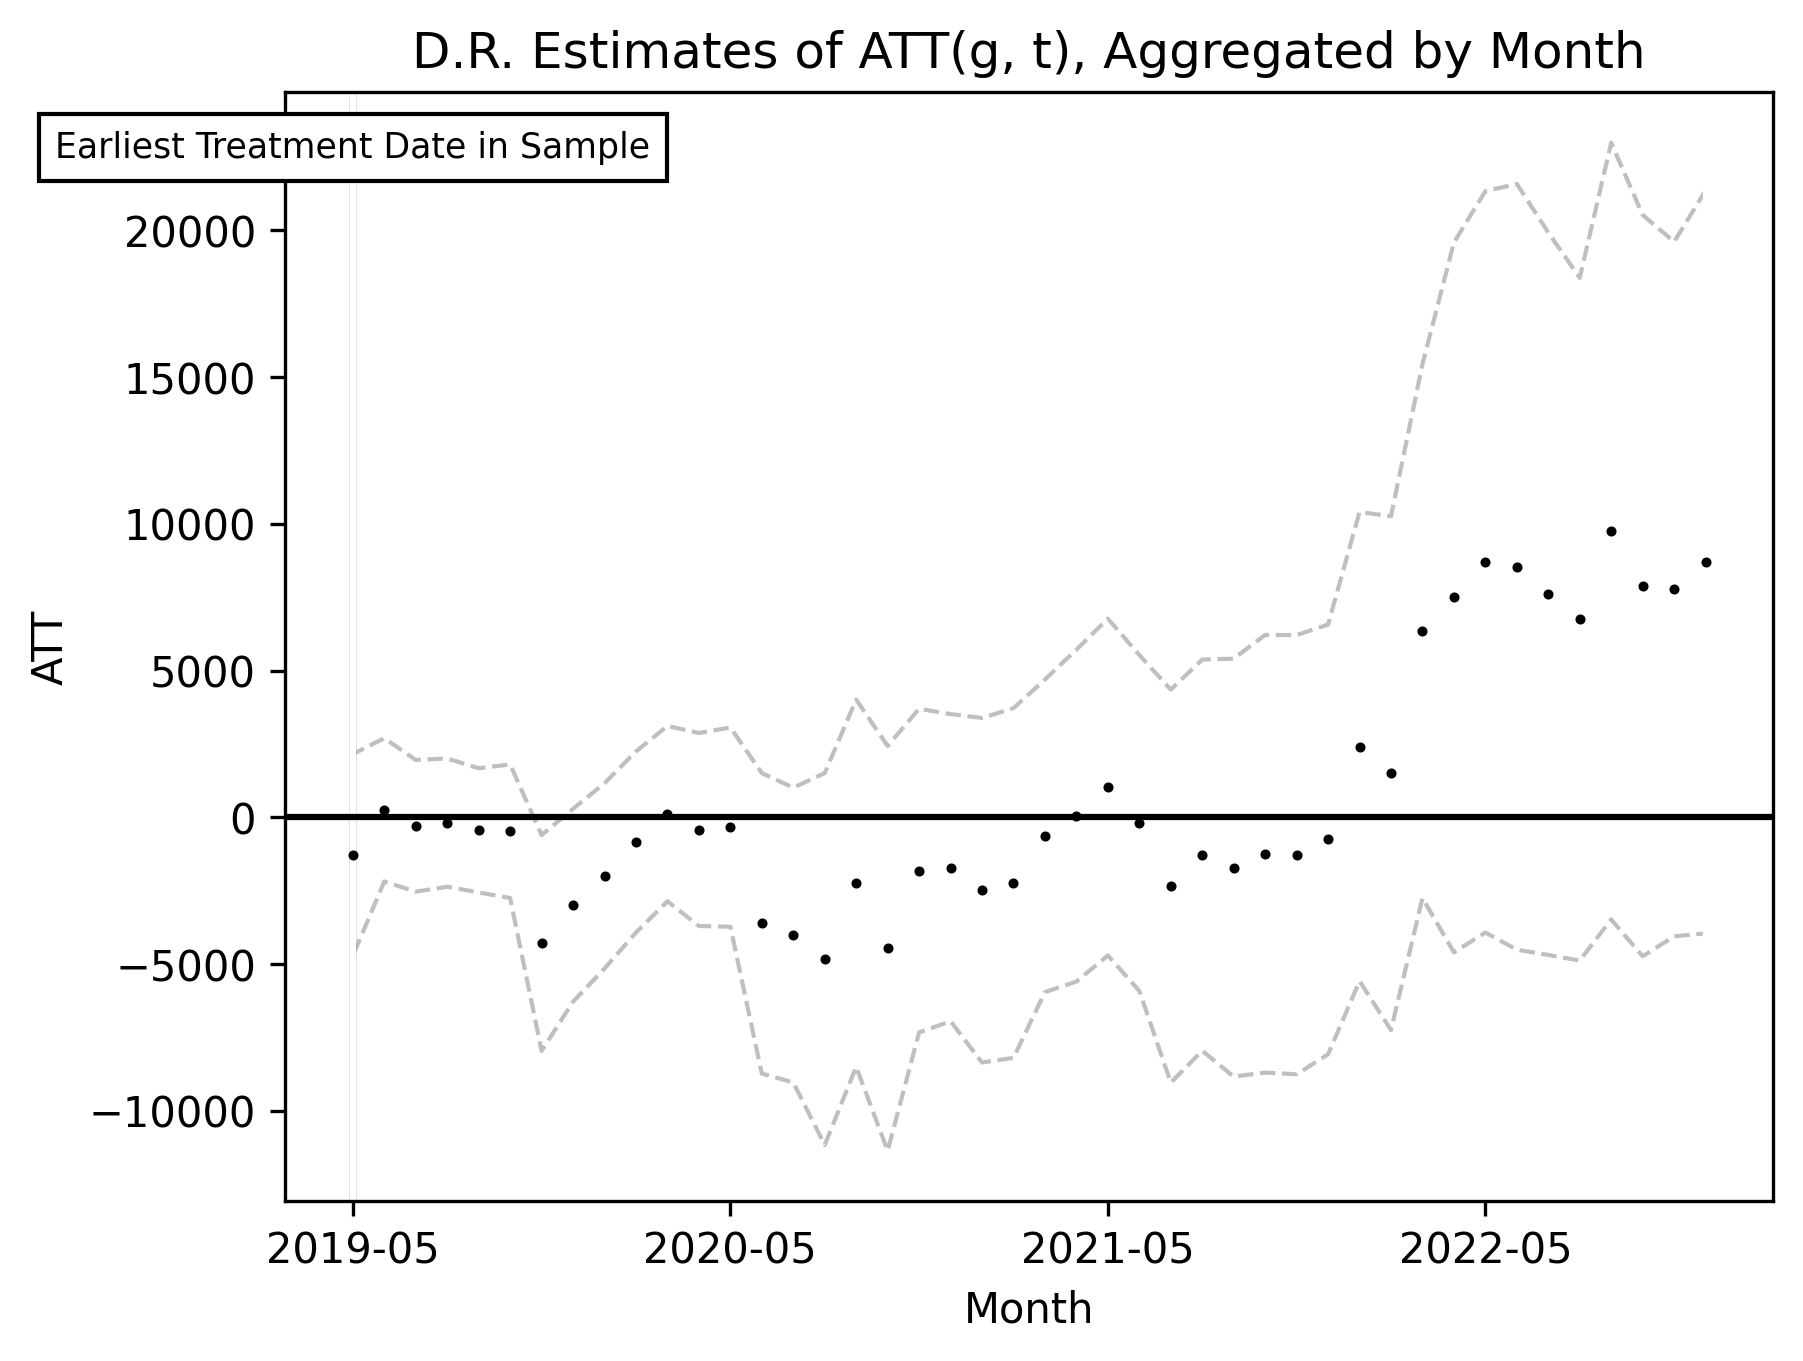

In [21]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")

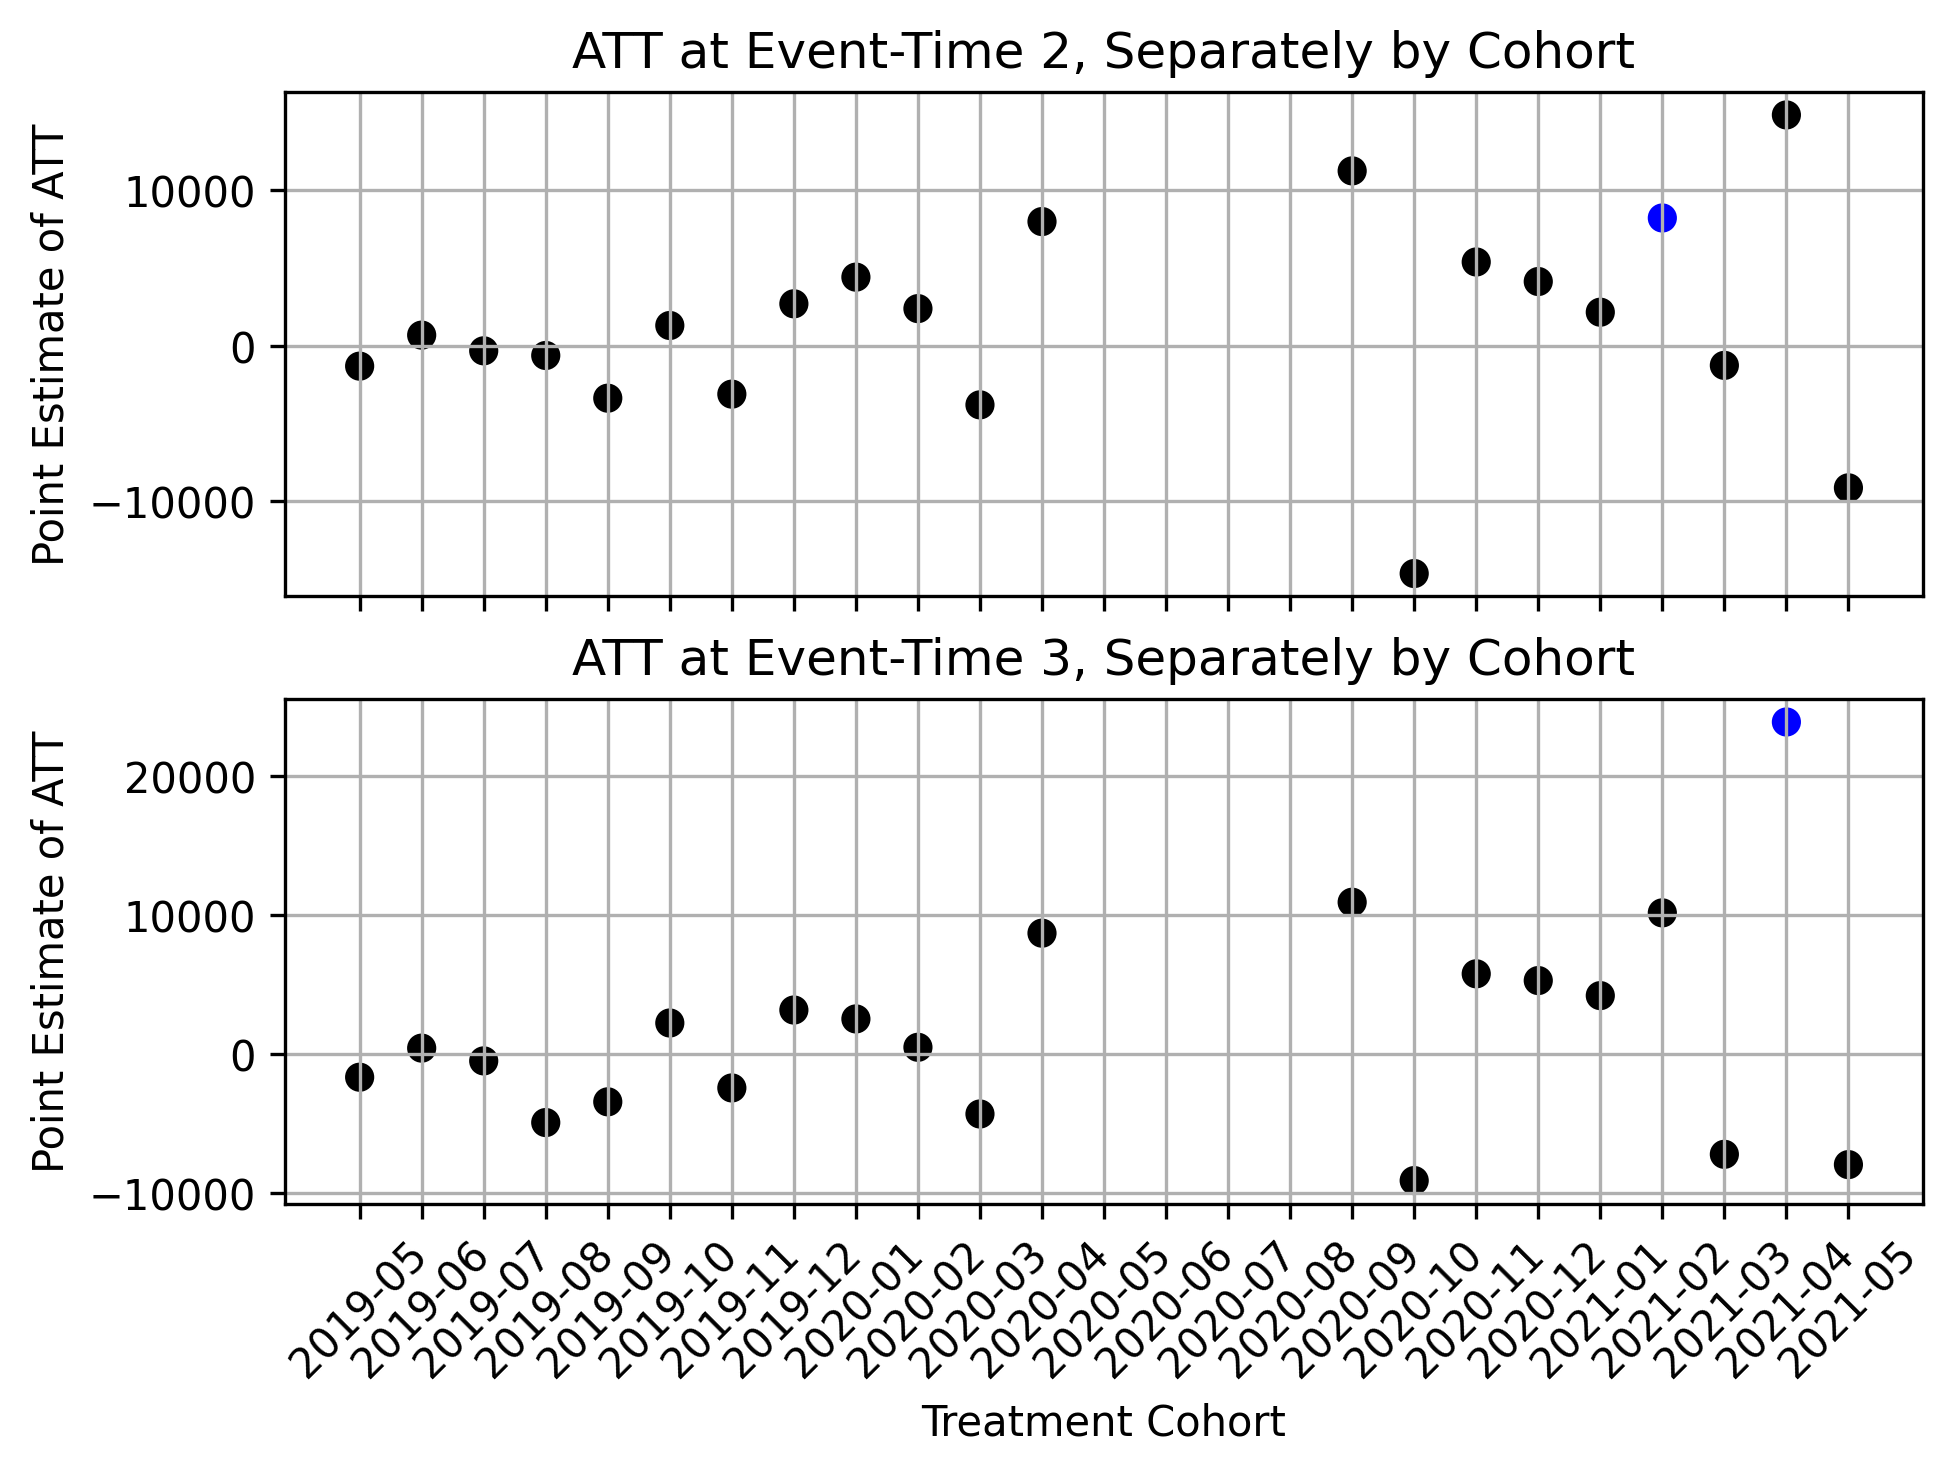

In [22]:
# Analyze heterogeneity in event-time 2 and 3 effects.

# Remove the outer indices of the columns so that we can easily access the ATT estimate and the significance of the estimate.
att_gts = result.copy()
att_gts.columns = att_gts.columns.droplevel(0).droplevel(0)

# Select ATT estimates from event time 2.
event_time_2_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'ATT']
event_time_2_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'zero_not_in_cband']

# Select ATT estimates from event time 3.
event_time_3_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'ATT']
event_time_3_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'zero_not_in_cband']

fig, axes = plt.subplots(2, 1, sharex=True, layout='constrained')

for event_time_i_ATTS, event_time_i_significance, xlabel, ylabel, title, ax in zip([event_time_2_ATTs, event_time_3_ATTs],
                                                                                   [event_time_2_significance, event_time_3_significance],
                                                                                   ["", "Treatment Cohort"],
                                                                                   ["Point Estimate of ATT", "Point Estimate of ATT"],
                                                                                   ["ATT at Event-Time 2, Separately by Cohort",
                                                                                    "ATT at Event-Time 3, Separately by Cohort"],
                                                                                   axes):
    x = pd.Series(event_time_i_ATTS.index.get_level_values(0)).replace(int_to_month_dictionary).values.tolist()
    y = event_time_i_ATTS.values.tolist()
    colors = event_time_i_significance.replace({'*': 'blue', '': 'black'}).values.tolist()
    ax.scatter(x,
               y,
               color=colors)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
axes[1].tick_params('x', rotation=45)
plt.show()

In [23]:
print(pre_treatment_covariates)

['twenty_seventeen_zestimate', 'change_in_zestimates', 'frac_coll_plus2010', 'job_density_2013', 'med_hhinc2016', 'popdensity2010', 'rent_twobed2015', 'share_white2010', 'traveltime15_2010', 'for_cause', 'isEntityD', 'rent_twobed2015_missing']
